# Digging in – theory, set-up and raster chat



## Patching rasters

Exercises:
1. Import two rasters into the database `giws` table `patch`
2. Check the pixel alignment
3. Align the pixels of the rasters to match
4. Update one of the rasters with the content of the other

Data we use:
1. Digital terrain model, from LiDAR (1 x 1)
2. Digital terrain model patch, from SfM (1 x 1)

## Digging in

In [3]:
%run examples_patch.ipynb
%run plpgsql_helpers.ipynb
%run sql_magics.ipynb

CREATE FUNCTION
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of bands constraint
NOTICE:  Adding pixel type constraint
NOTICE:  Adding nodata value constraint
NOTICE:  Adding out-of-database constraint
NOTICE:  Adding maximum extent constraint
 addrasterconstraints 
----------------------
 t
(1 row)

 x  | y | val |                   geom                   
----+---+-----+------------------------------------------
  1 | 1 |   1 | POLYGON((0 0,1 0,1 -1,0 -1,0 0))
  2 | 1 |   2 | POLYGON((1 0,2 0,2 -1,1 -1,1 0))
  3 | 1 |   3 | POLYGON((2 0,3 0,3 -1,2 -1,2 0))
  4 | 1 |   4 | POLYGON((3 0,4 0,4 -1,3 -1,3 0))
  5 | 1 |   5 | POLYGON((4 0,5 0,5 -1,4 -1,4 0))
  6 | 1 |   6 | POLYGON((5 0,6 0,6 -1,5 -1,5 0))
  7 | 1 |   7 | POLYGON((6 0,7 0,7 -1,6 -1,6 0))
  8 | 1 |   8 | POLYGON((7 0,8 0,8 -1,7 -1,7

The ST_Union function is one way to patch our DTM with a piece of the other DTM. But for it to work, rasters have to have the same alignment:

*In order for rasters to be unioned, they must all have the same alignment. Use ST_SameAlignment and ST_NotSameAlignmentReason for more details and help. One way to fix alignment issues is to use ST_Resample and use the same reference raster for alignment.* https://postgis.net/docs/RT_ST_Union.html

In [4]:
%%sql

-- ST_SameAlignment returns false and raises a notice

SELECT ST_SameAlignment(
        ( SELECT rast FROM patch), 
        ( SELECT rast FROM dtm limit 1)
    )

NOTICE:  The rasters (pixel corner coordinates) are not aligned
 st_samealignment 
------------------
 f
(1 row)



### ST_Resample - aligning the patch

https://postgis.net/docs/RT_ST_Resample.html

In [5]:
%%sql
 DROP TABLE IF EXISTS patch_resampled;
 SELECT 1 AS rid,
    ST_Resample(
        ( SELECT patch.rast FROM patch), 
        ( SELECT dtm.rast FROM dtm limit 1) -- a reference for grid origin, scalex, scaley, skewx & skewy
    ) AS rast INTO patch_resampled;

    SELECT rid, (foo.md).*
     FROM (SELECT rid, ST_MetaData(rast) As md
    FROM patch_resampled) As foo;

NOTICE:  table "patch_resampled" does not exist, skipping
 rid | upperleftx | upperlefty | width | height | scalex | scaley | skewx | skewy | srid | numbands 
-----+------------+------------+-------+--------+--------+--------+-------+-------+------+----------
   1 |          1 |         -1 |     5 |      5 |      1 |     -1 |     0 |     0 | 3794 |        1
(1 row)



In [6]:
%%sql

SELECT visualize_tiles_and_pixels('patch_resampled');

 visualize_tiles_and_pixels 
----------------------------
 
(1 row)



## Let's start to visualize our data: open up QGIS

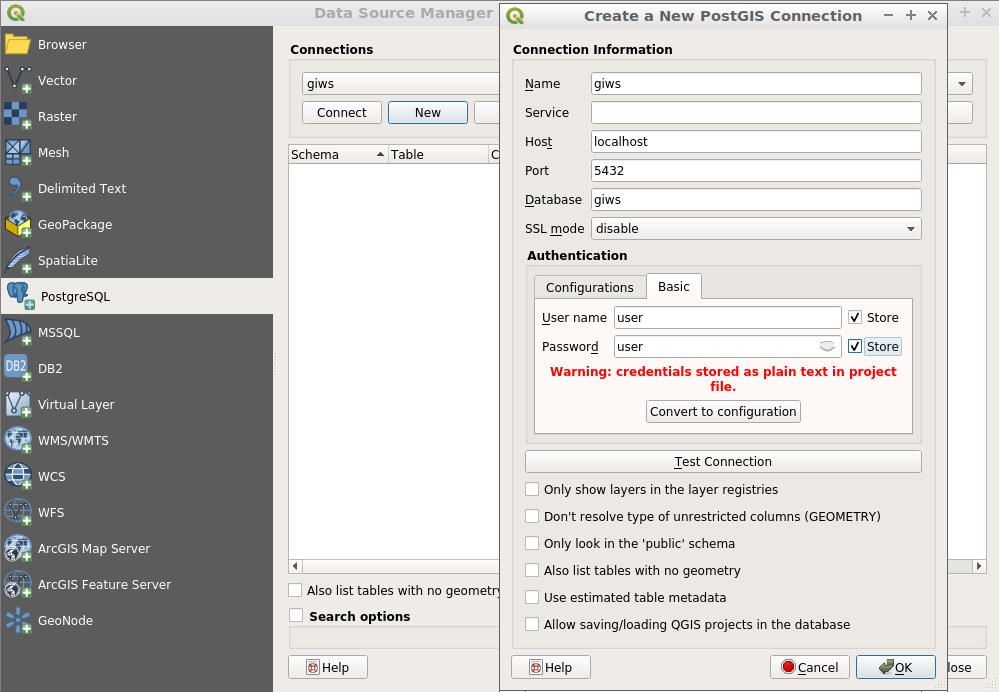

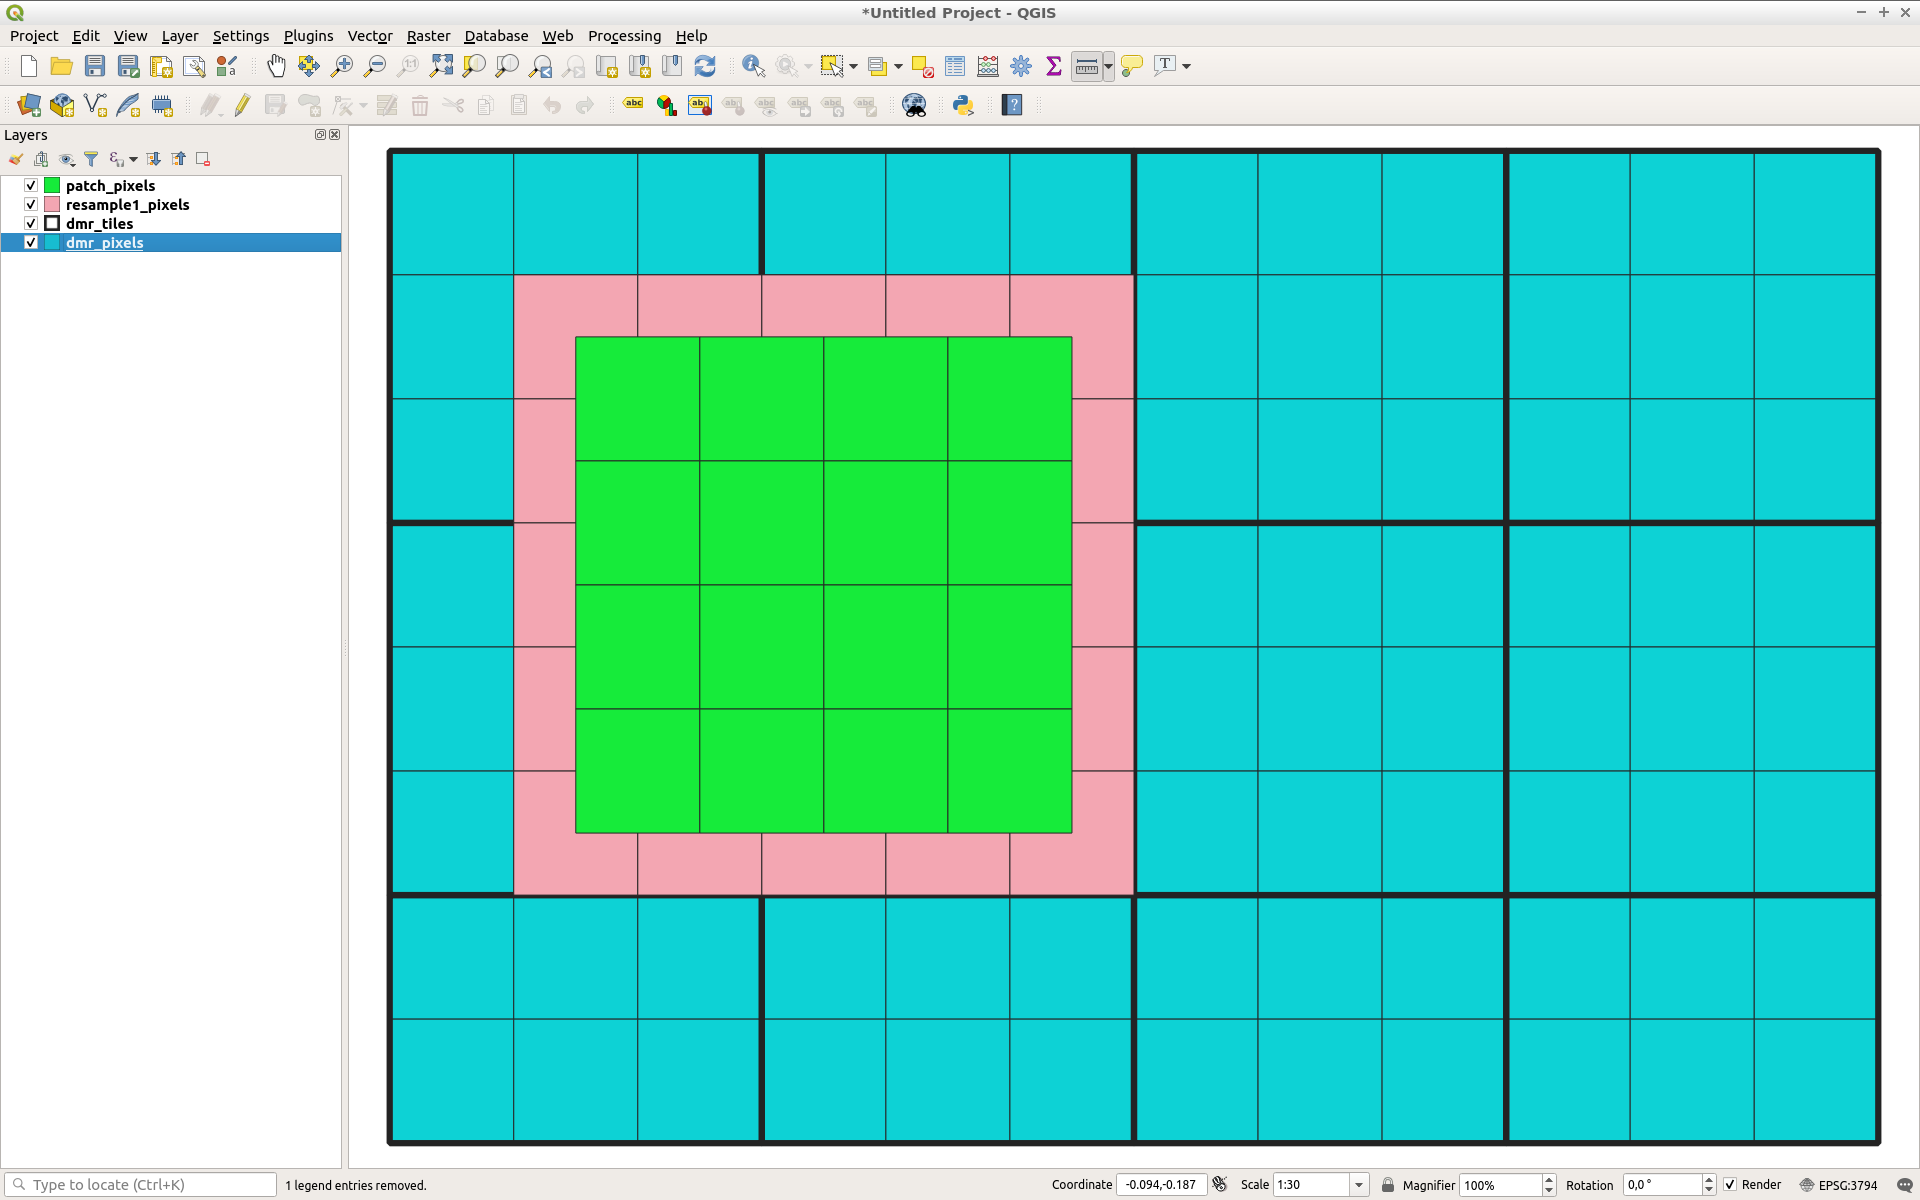

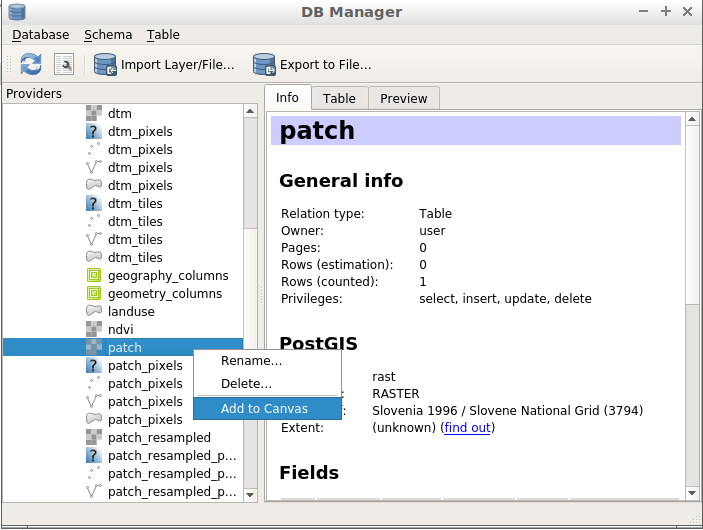

In [7]:
%%sql

-- ST_SameAlignment now returns true

SELECT ST_SameAlignment(
        ( SELECT rast FROM patch_resampled), 
        ( SELECT rast FROM dtm limit 1)
    )

 st_samealignment 
------------------
 t
(1 row)



The resampled pixels are now aligned to the DTM's pixels, however, the resampled patch increased in size and has additional NODATA pixels in the right column and in the bottom row.

### ST_Union

https://postgis.net/docs/RT_ST_Union.html

```sql
raster ST_Union(setof raster rast);
raster ST_Union(setof raster rast, unionarg[] unionargset);
raster ST_Union(setof raster rast, integer nband);
raster ST_Union(setof raster rast, text uniontype);
raster ST_Union(setof raster rast, integer nband, text uniontype);
```
The data type of a raster argument to the ST_Union is `setof raster`. Do note that `setof` is not the same as `array` or single `raster` arguments.

https://gis.stackexchange.com/questions/263962/how-to-merge-two-rgb-raster-tables-with-overlap-by-max-in-each-band-in-postgis

### Let's examine how ST_Union works

In [8]:
%run examples_union.ipynb

CREATE FUNCTION
NOTICE:  table "patch1" does not exist, skipping
NOTICE:  table "patch2" does not exist, skipping
DROP TABLE
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of bands constraint
NOTICE:  Adding pixel type constraint
NOTICE:  Adding nodata value constraint
NOTICE:  Adding out-of-database constraint
NOTICE:  Adding maximum extent constraint
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of bands constraint
NOTICE:  Adding pixel type constraint
NOTICE:  Adding nodata value constraint
NOTICE:  Adding out-of-database constraint
NOTICE:  Adding maximum extent constraint
 visualize_tiles_and_pixels 


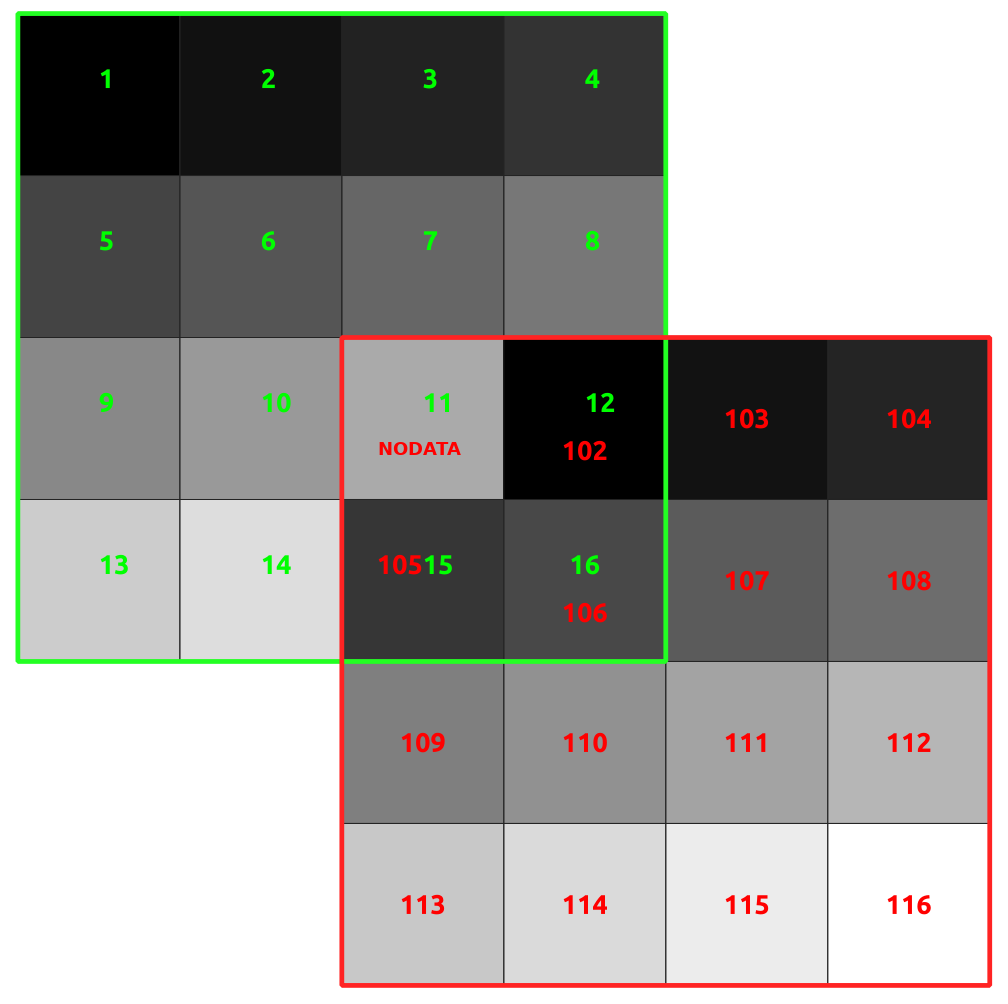

In [9]:
%%sql
CREATE OR REPLACE VIEW raster_union AS
SELECT 1 rid, ST_Union(rast) rast
FROM (SELECT rast FROM patch1
      UNION ALL
      SELECT rast FROM patch2) foo

CREATE VIEW


In [10]:
%%sql

SELECT visualize_tiles_and_pixels('raster_union');

 visualize_tiles_and_pixels 
----------------------------
 
(1 row)



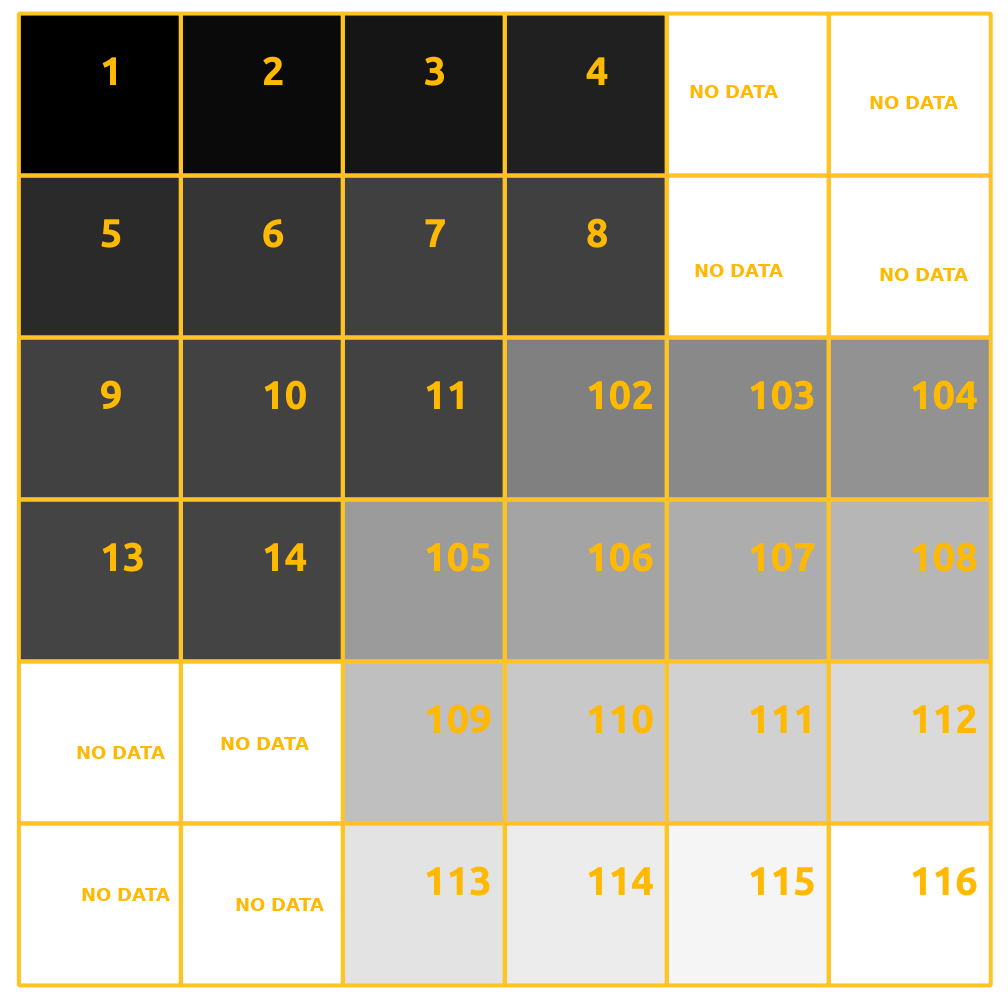
<center>The result of ST_Union</center>

Let's return to our test DTM example:

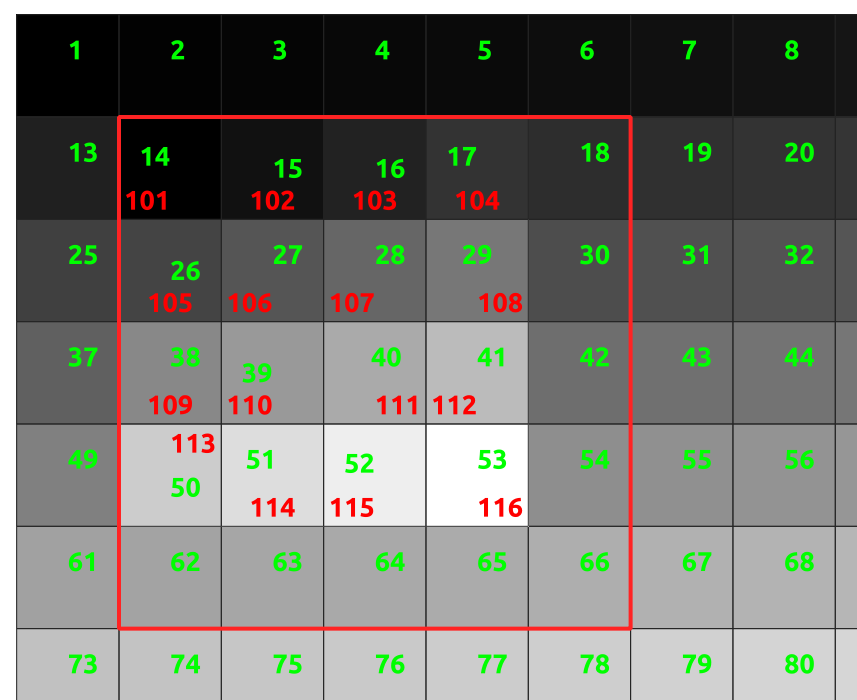

<center> We would like to patch the pixels with the green numbers (DTM) with the red numbered pixels (patch resampled)</center>

Our test example can simply be patched like this:

In [11]:
%%sql
CREATE OR REPLACE VIEW dtm_raster_union1 AS
SELECT 1 rid, ST_Union(rast) rast
FROM (SELECT rast FROM dtm 
      UNION ALL
      SELECT rast FROM patch_resampled) foo

CREATE VIEW


Most likely this won't work well with larger rasters, therefore let's refine our approach and focus only to the intersecting tiles:

In [12]:
%%sql
CREATE OR REPLACE VIEW dtm_raster_union2 AS
SELECT 1 rid, ST_Union(rast) rast
FROM (SELECT dtm.rast FROM dtm, patch_resampled WHERE 
          dtm.rast && patch_resampled.rast AND
          NOT ST_Touches(dtm.rast, patch_resampled.rast)
      UNION ALL
      SELECT rast FROM patch_resampled) foo

CREATE VIEW


This works but it would be good if we could update the DTM only with the modified tiles.

In [13]:
%%sql

DROP TABLE IF EXISTS patch_resampled CASCADE;
 SELECT 1 AS rid,
    ST_Resample(
        ( SELECT patch.rast FROM patch), 
        ( SELECT dtm.rast FROM dtm limit 1) -- a reference for grid origin, scalex, scaley, skewx & skewy
    ) AS rast INTO patch_resampled;

DROP TABLE IF EXISTS dtm_intersecting_tiles CASCADE;
CREATE TABLE dtm_intersecting_tiles AS (
        SELECT dtm.rid, dtm.rast 
        FROM dtm, patch_resampled 
        WHERE dtm.rast && patch_resampled.rast
        AND NOT ST_Touches(dtm.rast, patch_resampled.rast)
    );

DROP TABLE IF EXISTS patch_intersecting_tiles CASCADE;
CREATE TABLE patch_intersecting_tiles AS (
        SELECT dtm_intersecting_tiles.rid rid, ST_Clip(patch_resampled.rast, ST_Envelope(dtm_intersecting_tiles.rast)) rast
        FROM dtm_intersecting_tiles,patch_resampled 
    );

CREATE OR REPLACE VIEW dtm_raster_union3 AS
        SELECT a.rid rid, ST_Union(rast) rast from
        (SELECT * from dtm_intersecting_tiles
        UNION ALL
        SELECT * from patch_intersecting_tiles) a
        group by a.rid
      

NOTICE:  drop cascades to 4 other objects
DETAIL:  drop cascades to view patch_resampled_pixels
drop cascades to view dtm_raster_union1
drop cascades to view dtm_raster_union2
drop cascades to view patch_resampled_tiles
NOTICE:  table "dtm_intersecting_tiles" does not exist, skipping
NOTICE:  table "patch_intersecting_tiles" does not exist, skipping
CREATE VIEW


We have taken the union of clipped parts of our patch and underlying tiles (the rid of each clipped patch corresponds to the rid of the DTM tile by which it was clipped) and then performed ST_Union on the groups by rid (sets of two rasters).

You might have also noticed that patch_resampled was clipped to the underlying tiles of the DTM using `ST_Clip` function (https://postgis.net/docs/RT_ST_Clip.html).

In [12]:
%%sql
SELECT visualize_tiles_and_pixels('dtm_raster_union3');

 visualize_tiles_and_pixels 
----------------------------
 
(1 row)



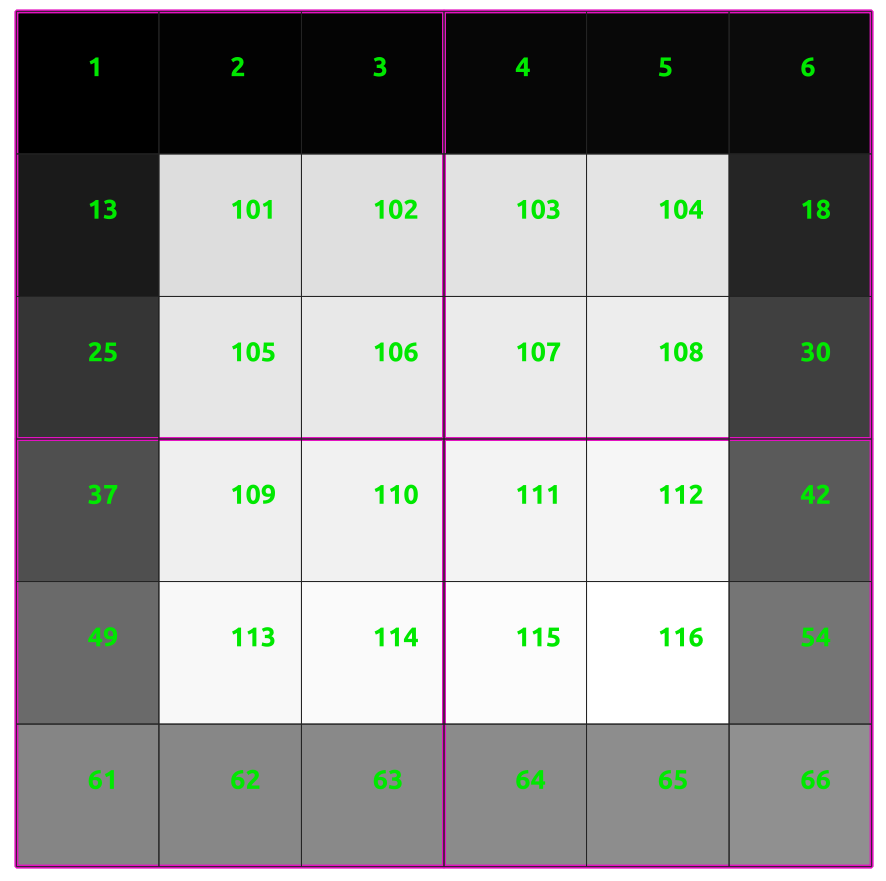

<center>dtm_raster_union3 - violet are the resulting raster tiles which are aligned with the DTM tiles</center>

There is still one final step to do - update the corresponding tiles in the DTM raster:

In [14]:
%%sql

UPDATE dtm

SET
    rast = ru.rast

FROM 

 dtm_raster_union3 ru

WHERE
    
    dtm.rid = ru.rid

UPDATE 4


In [14]:
%%sql
SELECT rast from dtm_raster_union3

                                                                       rast                                                                       
--------------------------------------------------------------------------------------------------------------------------------------------------
 0100000100000000000000F03F000000000000F0BF000000000000000000000000000008C000000000000000000000000000000000D20E0000030003004400256D6E3171723D3E3F
 0100000100000000000000F03F000000000000F0BF000000000000084000000000000008C000000000000000000000000000000000D20E00000300030044006F702A737436404142
 0100000100000000000000F03F000000000000F0BF0000000000000840000000000000000000000000000000000000000000000000D20E00000300030044000405066768126B6C1E
 0100000100000000000000F03F000000000000F0BF0000000000000000000000000000000000000000000000000000000000000000D20E00000300030044000102030D656619696A
(4 rows)



## Importing rasters

In [15]:
# first we need a database to store the raster. We created it before, but let's repeat:
!createdb -U user -h localhost giws

createdb: database creation failed: ERROR:  database "giws" already exists


In [16]:
# the database has to have a PostGIS extension enabled
!psql -U user -h localhost -d giws -c "CREATE EXTENSION postgis;"

ERROR:  extension "postgis" already exists


### `raster2pgsql`

> The raster2pgsql is a raster loader executable that loads GDAL supported raster formats into sql suitable for loading into a PostGIS raster table. It is capable of loading folders of raster files as well as creating overviews of rasters. -- https://postgis.net/docs/using_raster_dataman.html

In [17]:
%%sql
--supported and enabled drivers:

SELECT short_name, long_name, can_write
FROM ST_GDALDrivers();

     short_name      |                        long_name                         | can_write 
---------------------+----------------------------------------------------------+-----------
 GRASS               | GRASS Rasters (5.7+)                                     | f
 VRT                 | Virtual Raster                                           | t
 DERIVED             | Derived datasets using VRT pixel functions               | f
 GTiff               | GeoTIFF                                                  | t
 NITF                | National Imagery Transmission Format                     | t
 RPFTOC              | Raster Product Format TOC format                         | f
 ECRGTOC             | ECRG TOC format                                          | f
 HFA                 | Erdas Imagine Images (.img)                              | t
 SAR_CEOS            | CEOS SAR Image                                           | f
 CEOS                | CEOS Image                         

In [18]:
#let's import our test raster with no options to the table test1
!raster2pgsql -d /opt/workshop/exercise_1/patch.tif test1 | psql -h localhost -U user -d giws

Processing 1/1: /opt/workshop/exercise_1/patch.tif
BEGIN
NOTICE:  table "test1" does not exist, skipping
DROP TABLE
CREATE TABLE
INSERT 0 1
COMMIT


### How are rasters stored in database?

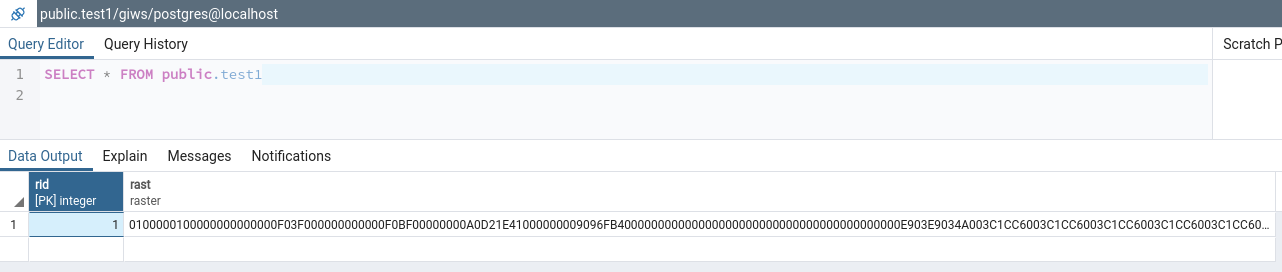

The output is in HEXWKB (Hexadecimal Well Known Binary) cf. https://github.com/postgis/postgis/blob/svn-trunk/raster/doc/RFC2-WellKnownBinaryFormat and stored on disk in rfc serialized format https://github.com/postgis/postgis/blob/svn-trunk/raster/doc/RFC1-SerializedFormat


There are two system table views involved in creating/importing raster files:

- raster_columns
- raster_overviews

### `raster2pgsql` options
Let's import a bigger raster file (clipped_dtm):

In [19]:
#check what we are going to import - this is not related to the import by itself
!gdalinfo /opt/workshop/exercise_1/DTM.tif

ERROR 4: /opt/workshop/exercise_1/DTM.tif: No such file or directory
gdalinfo failed - unable to open '/opt/workshop/exercise_1/DTM.tif'.


In [20]:
%%sql
DROP TABLE IF EXISTS dtm CASCADE;

NOTICE:  drop cascades to 4 other objects
DETAIL:  drop cascades to view dtm_pixels
drop cascades to view dtm_raster_union1
drop cascades to view dtm_raster_union2
drop cascades to view dtm_tiles
DROP TABLE


In [21]:
!raster2pgsql -d /opt/workshop/exercise_1/DTM.tif dtm | psql -h localhost -U user -d giws

ERROR: Unable to read raster file: /opt/workshop/exercise_1/DTM.tif


Depending on your hardware configuration, you may run out of memory.

When working with large raster it is recommended to tile it when importing. There are two options regarding tiles in `raster2pgsql`:

> -t *tile size* Cut raster into tiles to be inserted one per
      table row. *tile size* is expressed as WIDTHxHEIGHT.
      *tile size* can also be "auto" to allow the loader to compute
      an appropriate tile size using the first raster and applied to
      all rasters.
      
> -P Pad right-most and bottom-most tiles to guarantee that all tiles
     have the same width and height.
      
What should be the tile dimension? Of course it depends on what you are going to do with rasters ... there are some suggestions for the tile size, e.g. this one (https://gis.stackexchange.com/questions/31871/are-there-limitations-using-a-postgis-out-db-raster/32073#32073) by stackexchange user dustymugs (a PostGIS developer).

The benefit of having tiles is not only ability to import larger rasters - with tiles you can build effective spatial indexes over raster coverage and we know that spatial index is one of the key features of a spatial database which significantly speeds up spatial database queries (https://postgis.net/workshops/postgis-intro/indexing.html). You can build GIST spatial index on the raster column when importing:

> -I  Create a GIST spatial index on the raster column. The ANALYZE
      command will automatically be issued for the created index.

Another useful switch to speed up the import of a large raster is -Y (Use COPY statements instead of INSERT statements.)

The raster can be imported into the same table (use -a switch option in this case).

Usually we also set the constraints when importing:

> -C  Set the standard set of constraints on the raster
      column after the rasters are loaded. Some constraints may fail
      if one or more rasters violate the constraint
      
> -r  Set the constraints (spatially unique and coverage tile) for
      regular blocking. Only applied if -C flag is also used.

You can also build raster overviews when importing (option -l) which creates overviews in a saparate raster tables and fills the system table `raster_overviews` accordingly. This option's arguments are  comma-separated overview factors (https://postgis.net/docs/using_raster_dataman.html#RT_Raster_Overviews). There is also a PostGIS function `ST_CreateOverview` (https://postgis.net/docs/RT_CreateOverview.html) where you can also control the overview resampling algorithm.

In [22]:
%%sql
DROP TABLE IF EXISTS dtm CASCADE;
DROP TABLE IF EXISTS patch CASCADE;

NOTICE:  table "dtm" does not exist, skipping
NOTICE:  drop cascades to 2 other objects
DETAIL:  drop cascades to view patch_pixels
drop cascades to view patch_tiles
DROP TABLE


In [24]:
#let's import DTM.tif
!raster2pgsql -d -s 3794 -I /opt/workshop/exercise_1/DTM.tif -t 100x100 -Y -C -l 2,3,4,5,6,7,8,9,10 dtm | psql -h localhost -d giws -U user

Processing 1/1: /opt/workshop/exercise_1/DTM.tif
BEGIN
NOTICE:  table "dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_2_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_3_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_4_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_5_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_6_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_7_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_8_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_9_dtm" does not exist, skipping
DROP TABLE
NOTICE:  table "o_10_dtm" does not exist, skipping
DROP TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
CREATE TABLE
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11


COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11


COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11
COPY 11


 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

 addoverviewconstraints 
------------------------
 t
(1 row)

COMMIT


In [25]:
#import the patch
!raster2pgsql -d -s 3794 -I /opt/workshop/exercise_1/patch.tif -Y -C patch | psql -h localhost -d giws -U user

Processing 1/1: /opt/workshop/exercise_1/patch.tif
BEGIN
NOTICE:  table "patch" does not exist, skipping
DROP TABLE
CREATE TABLE
COPY 1
CREATE INDEX
ANALYZE
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of bands constraint
NOTICE:  Adding pixel type constraint
NOTICE:  Adding nodata value constraint
NOTICE:  Adding out-of-database constraint
NOTICE:  Adding maximum extent constraint
 addrasterconstraints 
----------------------
 t
(1 row)

COMMIT


We will drop the 'enforce_nodata_values_rast' constraint on DTM, because DTM hasn't got NODATA value defined and our patch has NODATA defined as -9999.

In [26]:
%%sql
SELECT DISTINCT ST_BandNoDataValue(rast,1) As bnval1 FROM (
SELECT * from patch) a

 bnval1 
--------
  -9999
(1 row)



In [27]:
%%sql
SELECT DISTINCT ST_BandNoDataValue(rast,1) As bnval1 FROM (
SELECT * from dtm) a

 bnval1 
--------
       
(1 row)



In [28]:
%%sql
ALTER TABLE dtm DROP CONSTRAINT enforce_nodata_values_rast;

ALTER TABLE


The other way would be to leave the constraint and update dtm with
```sql
UPDATE dtm
	SET rast = ST_SetBandNoDataValue(rast,1, -9999)
```

In [31]:
%%sql

DROP TABLE IF EXISTS patch_resampled CASCADE;
 SELECT 1 AS rid,
    ST_Resample(
        ( SELECT patch.rast FROM patch), 
        ( SELECT dtm.rast FROM dtm limit 1) -- a reference for grid origin, scalex, scaley, skewx & skewy
    ) AS rast INTO patch_resampled;

UPDATE dtm
SET
    rast = ru.rast
FROM 

(
    WITH
    
    dtm_intersecting_tiles AS (
        SELECT dtm.rid, dtm.rast 
        FROM dtm, patch_resampled 
        WHERE dtm.rast && patch_resampled.rast
        AND NOT ST_Touches(dtm.rast, patch_resampled.rast)
    ),
    
    patch_intersecting_tiles AS (
        SELECT dtm_intersecting_tiles.rid rid, ST_Clip(patch_resampled.rast, ST_Envelope(dtm_intersecting_tiles.rast)) rast
        FROM dtm_intersecting_tiles,patch_resampled 
    )
    
        SELECT a.rid rid, ST_Union(rast) rast from
        (SELECT * from dtm_intersecting_tiles
        UNION ALL
        SELECT * from patch_intersecting_tiles) a
        group by a.rid

) ru

WHERE
    dtm.rid = ru.rid

NOTICE:  drop cascades to 2 other objects
DETAIL:  drop cascades to view patch_resampled_pixels
drop cascades to view patch_resampled_tiles
UPDATE 121
